In [151]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.utils import resample

In [152]:
# Load the dataset
data = pd.read_csv('customer_data_public_sample_data.csv')

# Display the first few rows of the dataset
data.head()

,customer_id,name,gender,email,phone_number,account_age,last_login,num_transactions,avg_transaction_value,total_support_time,num_support_interactions,churn
0,1,Miss Kelly Obrien,Male,hodgessara@example.net,+1-914-910-7093x2769,54,2024-04-20,40,445.088444,79.026182,0,1
1,2,Sarah Oliver,Female,aaronsanchez@example.com,001-839-277-8709x20111,17,2024-05-23,90,440.625511,142.641377,8,0
2,3,Marvin Bray,Male,maurice20@example.com,654.337.2478x36183,9,2024-04-24,55,412.666430,39.843055,8,0
3,4,Claudia Blackburn,Male,chambersmarco@example.org,(214)465-7235x116,33,2024-04-19,87,405.513696,178.043001,7,0
4,5,Mrs. Tanya Berry,Male,kathleen44@example.net,+1-765-817-8598x78238,53,2024-03-12,39,187.105613,57.481919,7,0


In [153]:
# Convert 'last_login' column to datetime format
data['last_login'] = pd.to_datetime(data['last_login'], errors='coerce')

# Feature Engineering: Calculate the number of days since the first login
data['days_since_first_login'] = (data['last_login'] - data['last_login'].min()).dt.days

# Drop the 'last_login' column as it's no longer needed
data.drop(columns=['last_login'], inplace=True)

# Display the first few rows after feature engineering
data.head()

,customer_id,name,gender,email,phone_number,account_age,num_transactions,avg_transaction_value,total_support_time,num_support_interactions,churn,days_since_first_login
0,1,Miss Kelly Obrien,Male,hodgessara@example.net,+1-914-910-7093x2769,54,40,445.088444,79.026182,0,1,110
1,2,Sarah Oliver,Female,aaronsanchez@example.com,001-839-277-8709x20111,17,90,440.625511,142.641377,8,0,143
2,3,Marvin Bray,Male,maurice20@example.com,654.337.2478x36183,9,55,412.666430,39.843055,8,0,114
3,4,Claudia Blackburn,Male,chambersmarco@example.org,(214)465-7235x116,33,87,405.513696,178.043001,7,0,109
4,5,Mrs. Tanya Berry,Male,kathleen44@example.net,+1-765-817-8598x78238,53,39,187.105613,57.481919,7,0,71


In [154]:
# Convert categorical features (gender) to numerical using LabelEncoder
label_encoder = LabelEncoder()
data['gender'] = label_encoder.fit_transform(data['gender'])

# Display unique values in 'gender' column after encoding
data['gender'].unique()

array([1, 0])

In [155]:
# Drop non-relevant columns for prediction
features = data.drop(columns=['customer_id', 'name', 'email', 'phone_number', 'churn'])

# Create the target variable
target = data['churn']

# Display the features and target variable
print("Features:", features.columns)
print("Target:", target.name)


Features: Index(['gender', 'account_age', 'num_transactions', 'avg_transaction_value',
       'total_support_time', 'num_support_interactions',
       'days_since_first_login'],
      dtype='object')
Target: churn


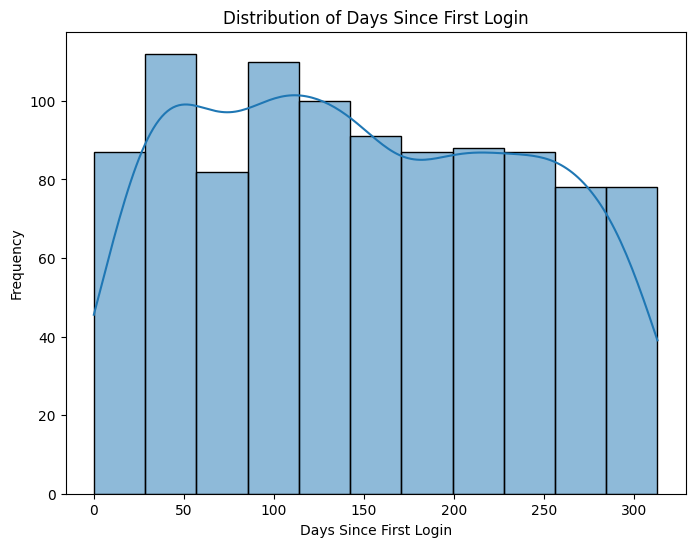

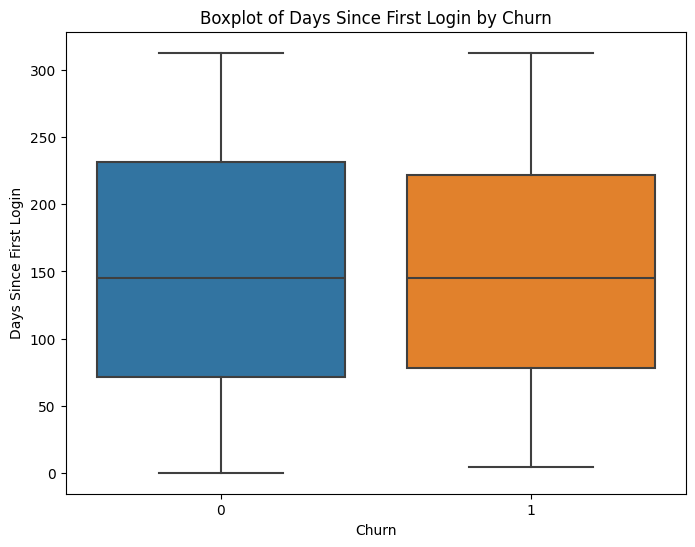

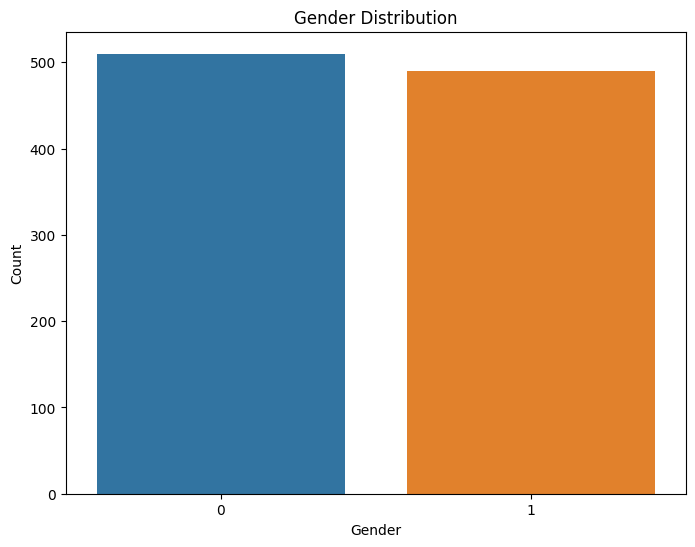

In [156]:
import matplotlib.pyplot as plt
import seaborn as sns

# a. Histogram for 'days_since_first_login'
plt.figure(figsize=(8, 6))
sns.histplot(data['days_since_first_login'], kde=True)
plt.title("Distribution of Days Since First Login")
plt.xlabel("Days Since First Login")
plt.ylabel("Frequency")
plt.show()

# b. Boxplot for 'days_since_first_login' by 'churn'
plt.figure(figsize=(8, 6))
sns.boxplot(x='churn', y='days_since_first_login', data=data)
plt.title("Boxplot of Days Since First Login by Churn")
plt.xlabel("Churn")
plt.ylabel("Days Since First Login")
plt.show()

# c. Bar Plot for 'gender' Distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='gender', data=data)
plt.title("Gender Distribution")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()


In [157]:
# Handling Class Imbalance: Upsample minority class (churned customers)
data_majority = data[data.churn == 0]
data_minority = data[data.churn == 1]

# Upsample minority class to match the majority class size
data_minority_upsampled = resample(data_minority, replace=True, n_samples=len(data_majority), random_state=42)

# Combine the majority and upsampled minority data
data_balanced = pd.concat([data_majority, data_minority_upsampled])

# Display the class distribution after balancing
print(f"Class distribution after balancing:\n{data_balanced['churn'].value_counts()}")


Class distribution after balancing:
0    515
1    515
Name: churn, dtype: int64


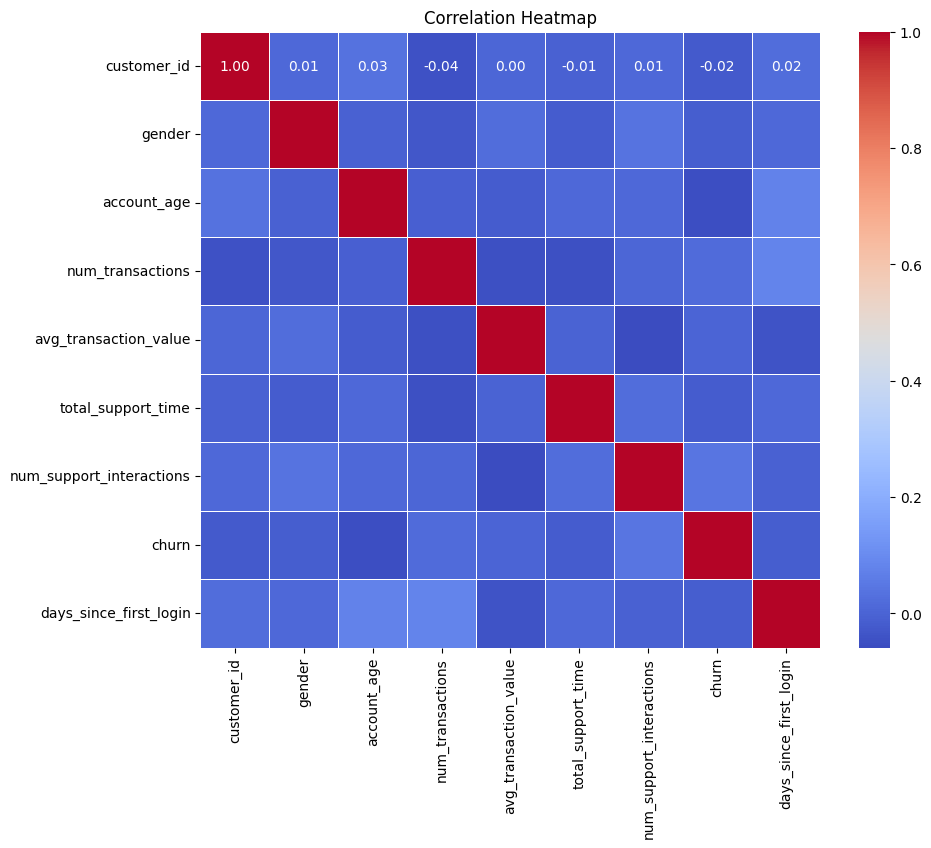

In [158]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

In [159]:
# Split data into features (X) and target (y)
X = data_balanced.drop(columns=['customer_id', 'name', 'email', 'phone_number', 'churn'])
y = data_balanced['churn']

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shape of the training and test sets
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")


Training set shape: (824, 7)
Test set shape: (206, 7)


In [160]:
# Initialize the models
logreg = LogisticRegression(max_iter=200)
dtree = DecisionTreeClassifier(random_state=42)
xgb = XGBClassifier(eval_metric='logloss', random_state=42)

# Print the model names
print(f"Models initialized: {logreg.__class__.__name__}, {dtree.__class__.__name__}, {xgb.__class__.__name__}")


Models initialized: LogisticRegression, DecisionTreeClassifier, XGBClassifier


In [161]:
# Train the models
logreg.fit(X_train, y_train)
dtree.fit(X_train, y_train)
xgb.fit(X_train, y_train)

# Print a message when training is complete
print("Training complete for all models.")


Training complete for all models.


In [162]:
# Make predictions using each model
logreg_pred = logreg.predict(X_test)
dtree_pred = dtree.predict(X_test)
xgb_pred = xgb.predict(X_test)

# Display a sample of predictions
print("Sample predictions (Logistic Regression):", logreg_pred[:5])
print("Sample predictions (Decision Tree):", dtree_pred[:5])
print("Sample predictions (XGBoost):", xgb_pred[:5])


Sample predictions (Logistic Regression): [0 0 1 1 0]
Sample predictions (Decision Tree): [0 0 0 0 1]
Sample predictions (XGBoost): [0 0 1 1 1]


In [163]:
# Define a function to evaluate models
def evaluate_model(model_name, y_true, y_pred):
    print(f"Model: {model_name}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("Classification Report:")
    print(classification_report(y_true, y_pred))
    print(f"AUC-ROC Score: {roc_auc_score(y_true, y_pred)}\n")


In [164]:
# Evaluate each model
evaluate_model("Logistic Regression", y_test, logreg_pred)
evaluate_model("Decision Tree", y_test, dtree_pred)
evaluate_model("XGBoost", y_test, xgb_pred)


Model: Logistic Regression
Confusion Matrix:
[[51 52]
 [56 47]]
Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.50      0.49       103
           1       0.47      0.46      0.47       103

    accuracy                           0.48       206
   macro avg       0.48      0.48      0.48       206
weighted avg       0.48      0.48      0.48       206

AUC-ROC Score: 0.47572815533980584

Model: Decision Tree
Confusion Matrix:
[[64 39]
 [24 79]]
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.62      0.67       103
           1       0.67      0.77      0.71       103

    accuracy                           0.69       206
   macro avg       0.70      0.69      0.69       206
weighted avg       0.70      0.69      0.69       206

AUC-ROC Score: 0.6941747572815533

Model: XGBoost
Confusion Matrix:
[[67 36]
 [22 81]]
Classification Report:
              precision    recal

In [165]:
# Export predictions for further analysis (e.g., Power BI integration)
predictions = pd.DataFrame({
    'customer_id': data.loc[X_test.index, 'customer_id'],
    'predicted_churn': xgb_pred
})

# Save the predictions to a CSV file
predictions.to_csv('churn_predictions.csv', index=False)

# Print confirmation of export
print("Predictions exported to 'churn_predictions.csv'.")


Predictions exported to 'churn_predictions.csv'.


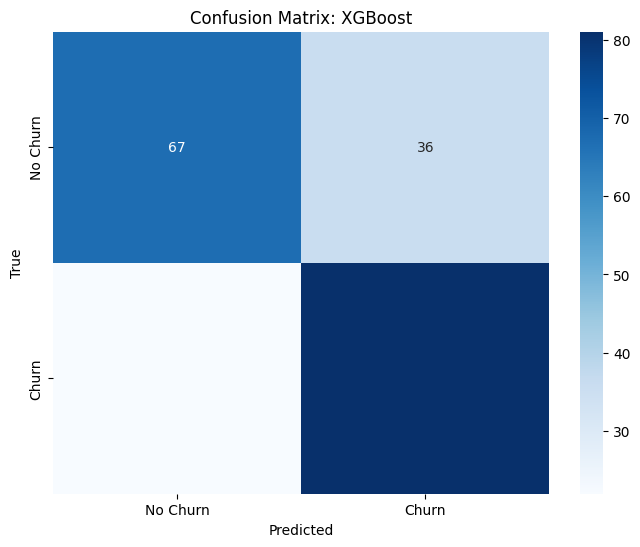

In [166]:
from sklearn.metrics import confusion_matrix

# Compute confusion matrix for XGBoost model
cm = confusion_matrix(y_test, xgb_pred)

# Plot confusion matrix using heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Churn", "Churn"], yticklabels=["No Churn", "Churn"])
plt.title("Confusion Matrix: XGBoost")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

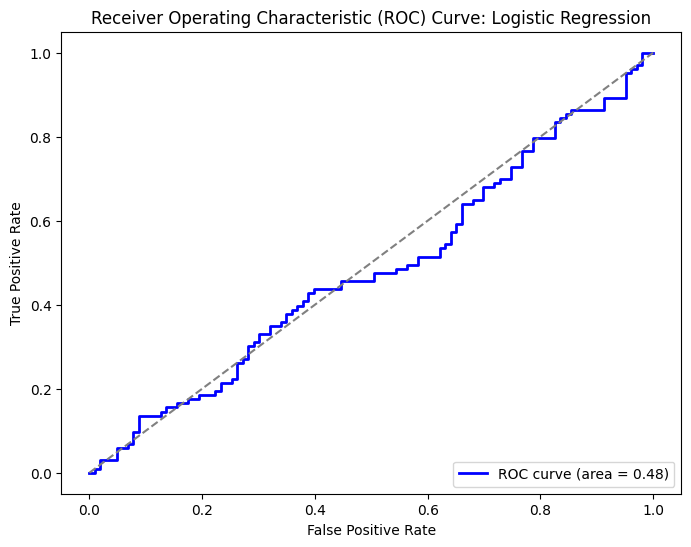

In [167]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve for Logistic Regression
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title("Receiver Operating Characteristic (ROC) Curve: Logistic Regression")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

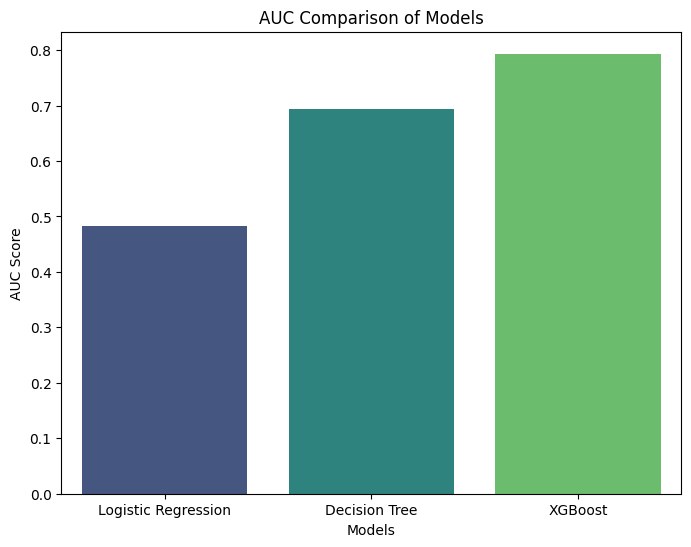

In [168]:
# Comparing AUC of different models
models = ['Logistic Regression', 'Decision Tree', 'XGBoost']
auc_scores = [roc_auc_score(y_test, logreg.predict_proba(X_test)[:, 1]),
              roc_auc_score(y_test, dtree.predict_proba(X_test)[:, 1]),
              roc_auc_score(y_test, xgb.predict_proba(X_test)[:, 1])]

plt.figure(figsize=(8, 6))
sns.barplot(x=models, y=auc_scores, palette='viridis')
plt.title("AUC Comparison of Models")
plt.xlabel("Models")
plt.ylabel("AUC Score")
plt.show()


<Figure size 1000x600 with 0 Axes>

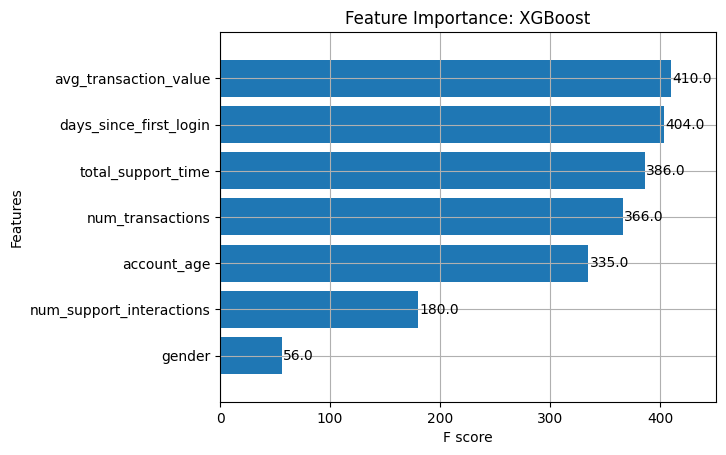

In [169]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Assuming your model is stored in 'xgb_model' (which is the trained XGBClassifier)
xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

# Plot feature importance directly from XGBClassifier
plt.figure(figsize=(10, 6))
xgb.plot_importance(xgb_model, importance_type='weight', max_num_features=10, height=0.8)
plt.title("Feature Importance: XGBoost")
plt.show()


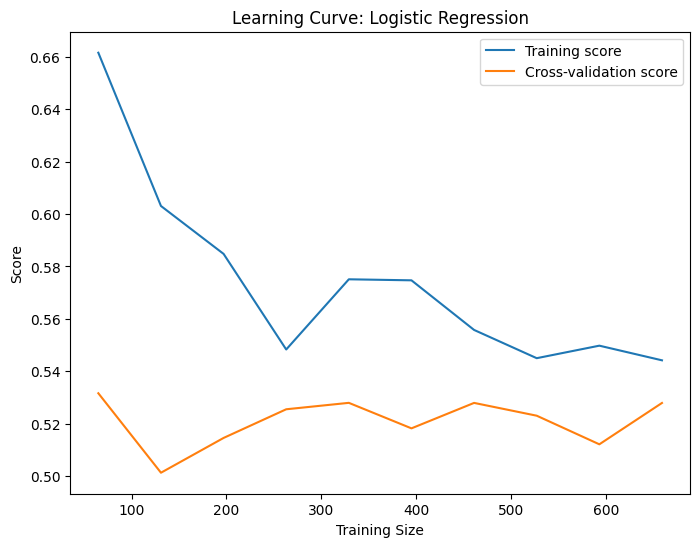

In [170]:
from sklearn.model_selection import learning_curve

# Generate learning curve for Logistic Regression
train_sizes, train_scores, test_scores = learning_curve(logreg, X_train, y_train, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

# Plot learning curve
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Cross-validation score')
plt.title("Learning Curve: Logistic Regression")
plt.xlabel("Training Size")
plt.ylabel("Score")
plt.legend()
plt.show()
